# CAR T Interaction Modeling with DIISCO

In [1]:
cd ..

/Users/shouvikmani/Desktop/DIISCO/DIISCO/diisco


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names


In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
# df = pickle.load(open('data/CAR-T ratios and umap/CARD_ratios.pkl', "rb"))
# cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
# df.columns = cell_types + ['total_cells_per_sample']
# # CARA expriment timestamps (hours post co-culture)
# df.index = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
# df.index.name = 'Hours post co-culture'
# df.to_csv('data/CAR-T ratios and umap/CARD_ratios_processed.pkl')

In [5]:
df = pd.read_csv('../../data/CAR-T ratios and umap/CARC_ratios_processed.pkl', index_col='Hours post co-culture')
df.columns = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells',
              'total_cells_per_sample']
df

,MEC1 cells,Other CD8+ T cells,Activated T cells,Exhausted T cells,total_cells_per_sample
Hours post co-culture,,,,,
0.000000,0.000000,0.000000,1.000000,0.000000,3.0
0.083333,0.773585,0.047170,0.179245,0.000000,106.0
0.250000,0.726852,0.055556,0.212963,0.004630,216.0
0.500000,0.691489,0.063830,0.234043,0.010638,188.0
1.000000,0.493363,0.030973,0.466814,0.008850,452.0
2.000000,0.613084,0.026168,0.349533,0.011215,535.0
4.000000,0.583333,0.010563,0.373239,0.032864,852.0
8.500000,0.388668,0.036282,0.072565,0.502485,2012.0
12.500000,0.266527,0.042497,0.093914,0.597062,1906.0


Text(0.5, 1.0, 'Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)')

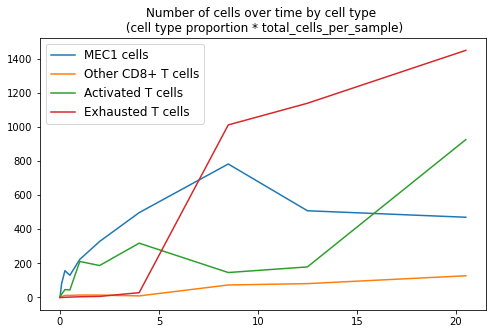

In [6]:
plt.figure(figsize=(8, 5))
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

Text(0, 0.5, 'Proportion')

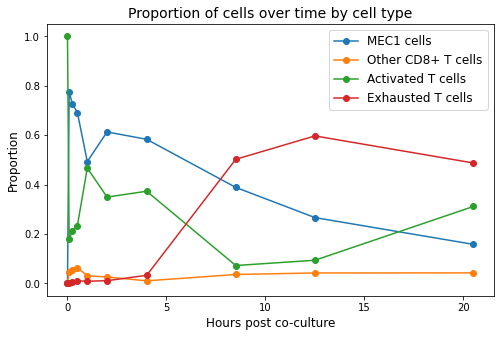

In [7]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
# plt.savefig('../../figures/CAR-T/fig_2_cell_type_proportions.eps')

In [8]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

array([[0.        ],
       [0.08333333],
       [0.25      ]])

In [9]:
Y = df[cell_types].values
Y

array([[0.        , 0.        , 1.        , 0.        ],
       [0.77358491, 0.04716981, 0.17924528, 0.        ],
       [0.72685185, 0.05555556, 0.21296296, 0.00462963],
       [0.69148936, 0.06382979, 0.23404255, 0.0106383 ],
       [0.49336283, 0.03097345, 0.46681416, 0.00884956],
       [0.61308411, 0.02616822, 0.34953271, 0.01121495],
       [0.58333333, 0.01056338, 0.37323944, 0.03286385],
       [0.38866799, 0.03628231, 0.07256461, 0.50248509],
       [0.26652676, 0.04249738, 0.09391396, 0.59706191],
       [0.15824916, 0.04276094, 0.31144781, 0.48754209]])

Prior for $W$

Text(0.5, 1.02, 'Interaction prior variances based on receptor-ligand expression')

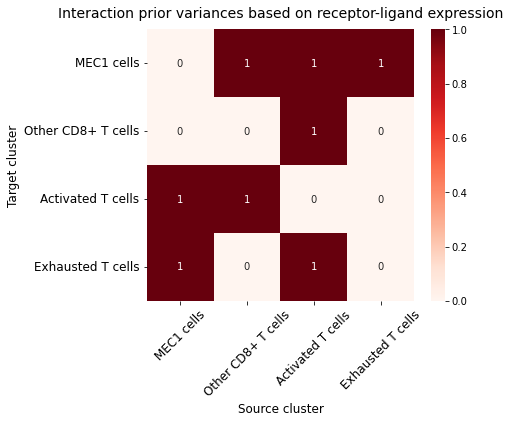

In [10]:
W_prior_variance = np.load('../../data/CAR-T/interaction_prior.npy')

plt.figure(figsize=(6, 5))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12, rotation=0)
ax.set_xticklabels(cell_types, fontsize=12, rotation=45)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [11]:
t_subset_num = 12
timepoints = torch.tensor(X)[:t_subset_num]
proportions = torch.tensor(Y)[:t_subset_num]
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

# z score the proportions
proportions_mean = proportions.mean(dim=0)
proportions_std = proportions.std(dim=0)
# proportions = proportions - proportions_mean
proportions = (proportions - proportions_mean)/ (proportions_std)
#proportions = proportions / proportions_std


print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 4])


In [12]:
def unscale(proportions, cluster_index): 
    return np.clip(proportions * 
                   proportions_std.detach().numpy()[cluster_index] + 
                   proportions_mean.detach().numpy()[cluster_index], 
                   0, None)

Text(0.5, 1.05, 'Cell type proportions (scaled)')

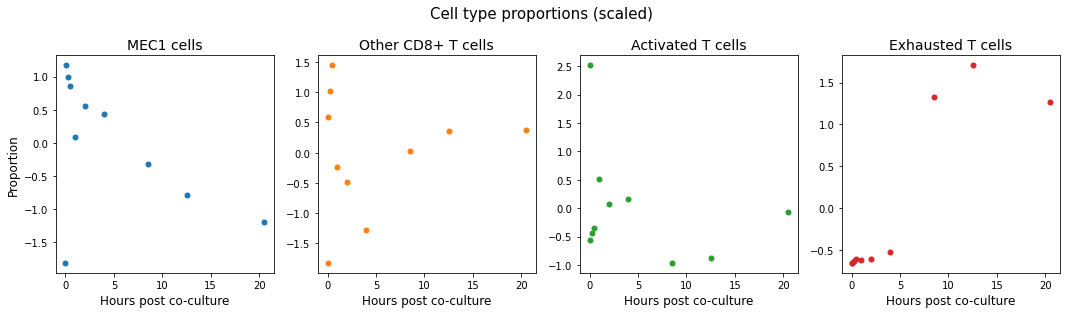

In [13]:
cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    ax.scatter(timepoints, proportions[:, i], c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
plt.suptitle('Cell type proportions (scaled)', fontsize=15, y=1.05)

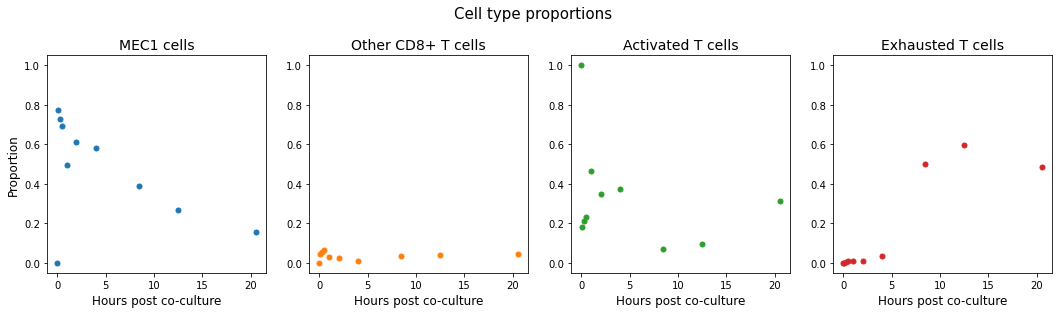

In [14]:
cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    ax.scatter(timepoints, unscale(proportions[:, i], i), c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
    ax.set_ylim([-0.05, 1.05])
plt.suptitle('Cell type proportions', fontsize=15, y=1.05)
plt.savefig('../../figures/CAR-T/cell_type_proportions.eps', bbox_inches="tight")

Heuristics for lengthscale

In [15]:
# mean of all intervals
lengthscale_f = np.mean(np.abs(X - X.T))
lengthscale_f

6.483333333333333

In [16]:
j = W_prior_variance.sum(axis=1).max()
lengthscale_W = max([X[i, 0] - X[i-j+1, 0] 
                     for i in range(j-1, X.shape[0])])
lengthscale_W

12.0

In [17]:
hyper_init_vals = {
    names.LENGTHSCALE_F: lengthscale_f,
    names.LENGTHSCALE_W: lengthscale_W,
    names.SIGMA_F: 0.5,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 6.483333333333333, 'lengthscale_w': 12.0, 'sigma_f': 0.5, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.5}


In [18]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

In [19]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)

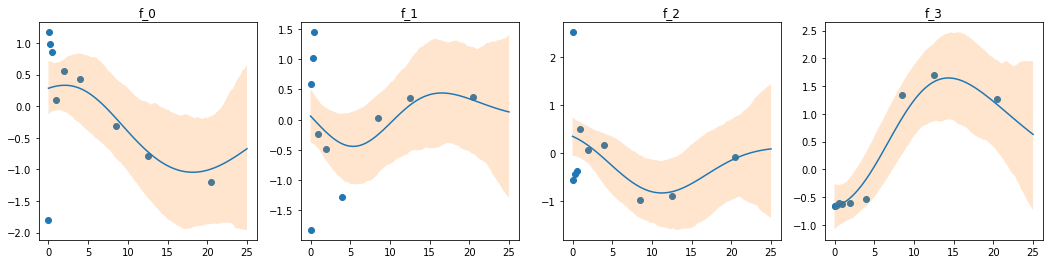

In [20]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(0, 25, 100).view(-1, 1)
fig, ax = plt.subplots(1, n_cell_types, figsize=(18, 4))

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)
for cell_type_idx in range(n_cell_types):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, cell_type_idx, :].detach().numpy()
    assert f_prior_cell_type_np.shape == (n_samples, n_eval_timepoints)

    mean = f_prior_cell_type_np.mean(axis=0)
    upper = np.percentile(f_prior_cell_type_np, 97.5, axis=0)
    lower = np.percentile(f_prior_cell_type_np, 2.5, axis=0)
    ax[cell_type_idx].scatter(timepoints, proportions[:, cell_type_idx].flatten().detach().numpy(), label=f'f_{cell_type_idx}')
    ax[cell_type_idx].plot(eval_timepoints_np, mean, label=f'f_{cell_type_idx}')
    ax[cell_type_idx].fill_between(eval_timepoints_np.flatten(), lower, upper, alpha=0.2)

    ax[cell_type_idx].set_title(f'f_{cell_type_idx}')


In [21]:
model.fit(timepoints, 
          proportions, 
          n_iter=10000, 
          lr=0.00005,
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 2965.3524
[iteration 0101] loss: 1586.5315
[iteration 0201] loss: 1437.2606
[iteration 0301] loss: 1428.9390
[iteration 0401] loss: 1424.8349
[iteration 0501] loss: 1314.1262
[iteration 0601] loss: 1259.0311
[iteration 0701] loss: 1221.2971
[iteration 0801] loss: 1177.6033
[iteration 0901] loss: 1159.1599
[iteration 1001] loss: 1164.6529
[iteration 1101] loss: 1146.4710
[iteration 1201] loss: 1110.4404
[iteration 1301] loss: 1112.8841
[iteration 1401] loss: 1061.4312
[iteration 1501] loss: 1078.6620
[iteration 1601] loss: 1043.3294
[iteration 1701] loss: 1088.1542
[iteration 1801] loss: 1031.4940
[iteration 1901] loss: 1032.7054
[iteration 2001] loss: 1042.6812
[iteration 2101] loss: 1013.7185
[iteration 2201] loss: 1009.6701
[iteration 2301] loss: 986.4425
[iteration 2401] loss: 996.7945
[iteration 2501] loss: 956.9920
[iteration 2601] loss: 950.7404
[iteration 2701] loss: 953.0664
[iteration 2801] loss: 990.5717
[iteration 2901] loss: 921.5636
[iteration 3001] 

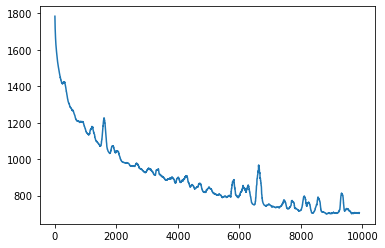

In [22]:
start = 0
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

Text(0.5, 1.05, 'DIISCO f samples')

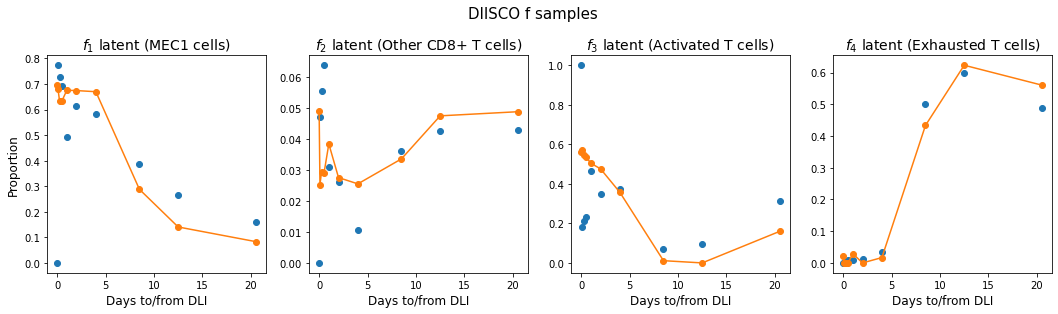

In [23]:
# Here we compared the learned latent proportions to the true latent proportions
f_mean = model.get_f_mean(n_samples=100)
f_mean = f_mean.detach().numpy()

plt.figure(figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    f_mean_i = unscale(f_mean[:, i], i)
    plt.subplot(1, 4, i+1)
    color = 'tab:blue'
    plt.plot(timepoints, f_mean_i, c='tab:orange', marker='o')
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color)
    plt.title('$f_{%s}$ latent (%s)' % (i+1, cell_type), fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('DIISCO f samples', fontsize=15, y=1.05)

Text(0.5, 1.05, 'DIISCO y samples')

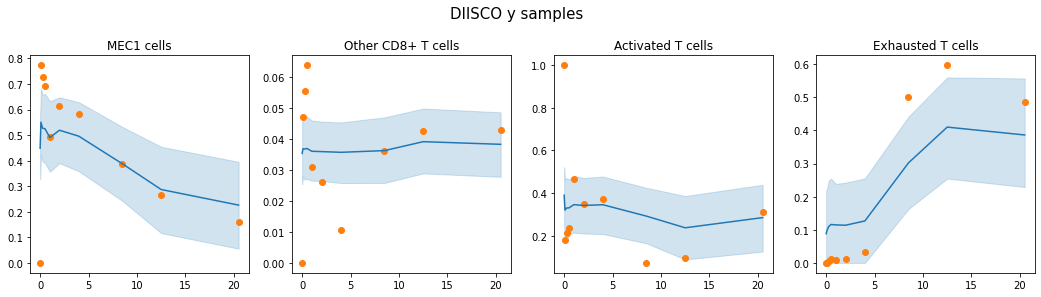

In [24]:
y = model.sample_observed_proportions(n_samples=1000).detach()

fig, axes = plt.subplots(1, n_cell_types, figsize=(18, 4))
for i in range(n_cell_types):
    cell_type_samples = y[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    axes[i].plot(timepoints, mean, c='tab:blue')
    axes[i].fill_between(timepoints.squeeze(), percentile_25, percentile_75, color='tab:blue', alpha=0.2)
    axes[i].scatter(timepoints, unscale(proportions[:, i], i), c='tab:orange')
    axes[i].set_title(cell_types[i])

plt.suptitle('DIISCO y samples', fontsize=15, y=1.05)

In [25]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                       n_samples=10000, 
                       n_samples_per_latent=10,
                       include_emission_variance=True)

100%|█████████████████████████████████████| 10000/10000 [00:25<00:00, 395.42it/s]


In [26]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

Text(0.5, 1.05, 'DIISCO f samples')

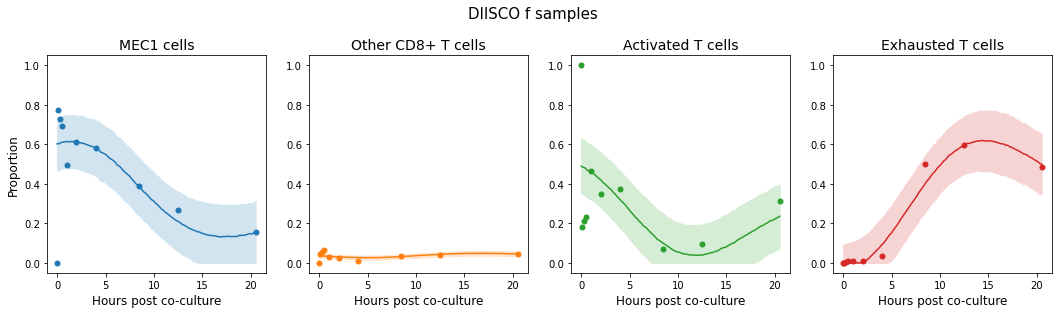

In [27]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    cell_type_samples = f_samples_predict[:, :, i, 0]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze().numpy()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    ax = axes[i]
    color_with_alpha = list(colors.to_rgb(cell_type_color[i][1])) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    line = ax.plot(x, mean, c=cell_type_color[i][1])
    ax.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    ax.scatter(timepoints, unscale(proportions[:, i], i), c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
    ax.set_ylim([-0.05, 1.05])
plt.suptitle('DIISCO f samples', fontsize=15, y=1.05)

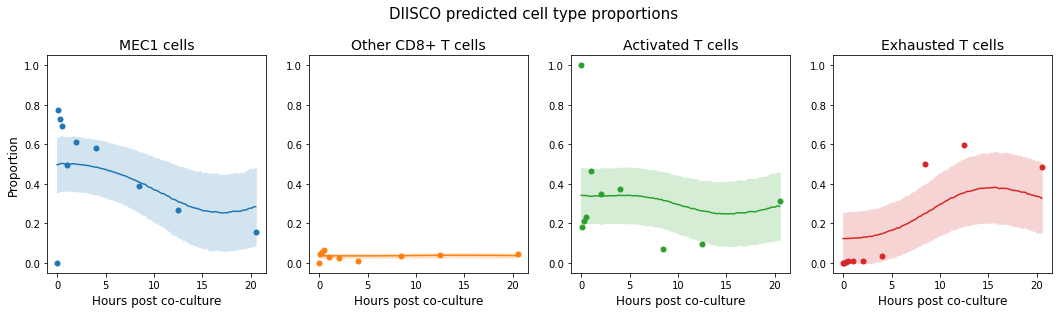

In [28]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze().numpy()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    ax = axes[i]
    color_with_alpha = list(colors.to_rgb(cell_type_color[i][1])) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    line = ax.plot(x, mean, c=cell_type_color[i][1])
    ax.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    ax.scatter(timepoints, unscale(proportions[:, i], i), c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
    ax.set_ylim([-0.05, 1.05])
plt.suptitle('DIISCO predicted cell type proportions', fontsize=15, y=1.05)
plt.savefig('../../figures/CAR-T/diisco_predicted_proportions.eps', bbox_inches="tight")

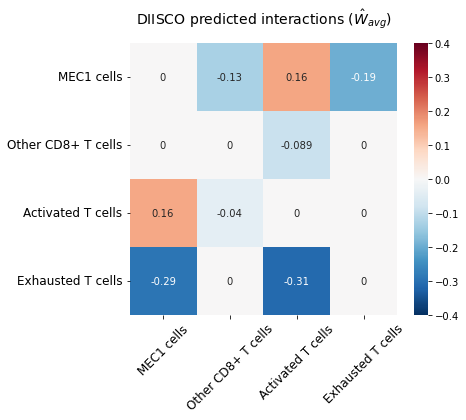

In [30]:
plt.figure(figsize=(6, 5))
W_avg_over_time = W_samples_predict.mean(axis=(0, 1)).detach().numpy()
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions ($\hat{W}_{avg})$', fontsize=14, y=1.05)
plt.savefig('../../figures/CAR-T/diisco_W_avg.eps', bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


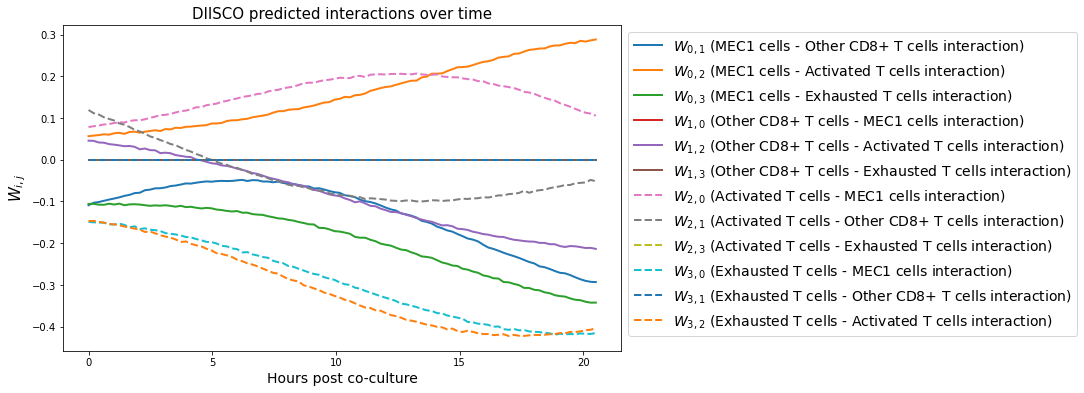

In [36]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        if i != j:
            plt.plot(predict_timepoints, 
                     W_samples_predict.mean(axis=0)[:, i, j].detach().numpy(),
                     linestyle=linestyles[i//2],
                     linewidth=2,
                     label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('DIISCO predicted interactions over time', fontsize=15)
plt.ylabel('$W_{i, j}$', fontsize=15)
plt.xlabel('Hours post co-culture', fontsize=14)
plt.savefig('../../figures/CAR-T/diisco_W_over_time.eps', bbox_inches="tight")

In [37]:
W_avg_edge_list = []

for row in range(W_avg_over_time.shape[0]):
    for col in range(W_avg_over_time.shape[0]):
        W_avg_edge_list.append({
            'Source cluster': cell_types[col],
            'Target cluster': cell_types[row],
            'Interaction weight': W_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_avg_over_time[row, col]),
            'sign(Interaction weight)': np.sign(W_avg_over_time[row, col])
        })

W_avg_edge_list_df = pd.DataFrame(W_avg_edge_list)
W_avg_edge_list_df.to_csv('../../data/CAR-T/W_avg_edge_list.csv')
W_avg_edge_list_df.head()

,Source cluster,Target cluster,Interaction weight,abs(Interaction weight),sign(Interaction weight)
0,MEC1 cells,MEC1 cells,0.000000,0.000000,0.0
1,Other CD8+ T cells,MEC1 cells,-0.128493,0.128493,-1.0
2,Activated T cells,MEC1 cells,0.158031,0.158031,1.0
3,Exhausted T cells,MEC1 cells,-0.194925,0.194925,-1.0
4,MEC1 cells,Other CD8+ T cells,0.000000,0.000000,0.0


In [38]:
y_preds_avg_over_samples = y_samples_predict.mean(axis=0).numpy()
y_preds_avg_over_time = y_preds_avg_over_samples.mean(axis=0)
y_preds_avg_over_time = [unscale(y, i) for i, y in enumerate(y_preds_avg_over_time)]
y_preds_df = pd.DataFrame(y_preds_avg_over_time, 
                          index=cell_types, 
                          columns=['Inferred cluster proportion'])
y_preds_df.index.name = 'Cell type'
y_preds_df.to_csv('../../data/CAR-T/predicted_cluster_props_avg.csv')
y_preds_df

,Inferred cluster proportion
Cell type,
MEC1 cells,0.371859
Other CD8+ T cells,0.037045
Activated T cells,0.297649
Exhausted T cells,0.270138


In [39]:
for hours_post_coculture in range(21):
    hours_nearest_X_index = np.argmin(np.abs(predict_timepoints - hours_post_coculture))
    y_t_preds_avg = [unscale(y, i) for i, y in 
                     enumerate(y_preds_avg_over_samples[hours_nearest_X_index])]
    y_preds_df = pd.DataFrame(y_t_preds_avg, 
                              index=cell_types, 
                              columns=['Inferred cluster proportion'])
    y_preds_df.index.name = 'Cell type'
    y_preds_df.to_csv(f'../../data/CAR-T/predicted_cluster_props_over_time/predicted_cluster_props_{hours_post_coculture}.csv')
    

In [44]:
W_avg_over_samples = W_samples_predict.mean(axis=0).numpy()

In [45]:
for hours_post_coculture in range(21):
    hours_nearest_X_index = np.argmin(np.abs(predict_timepoints - hours_post_coculture))
    W_t = W_avg_over_samples[hours_nearest_X_index]
    W_t_avg_edge_list = []
    for row in range(W_t.shape[0]):
        for col in range(W_t.shape[0]):
            W_t_avg_edge_list.append({
                'Source cluster': cell_types[col],
                'Target cluster': cell_types[row],
                'Interaction weight': W_t[row, col],
                'abs(Interaction weight)': np.abs(W_t[row, col]),
                'sign(Interaction weight)': np.sign(W_t[row, col])
            })

    W_t_avg_edge_list_df = pd.DataFrame(W_t_avg_edge_list)
    W_t_avg_edge_list_df.to_csv(f'../../data/CAR-T/W_edge_list_over_time/W_edge_list_{hours_post_coculture}.csv')

In [46]:
y_preds_unscaled = np.array([unscale(y, i) for i, y in enumerate(y_preds_avg_over_samples.T)]).T

np.save('../../data/CAR-T/X.npy', predict_timepoints.numpy())
np.save('../../data/CAR-T/y.npy', y_preds_unscaled)
np.save('../../data/CAR-T/W.npy', W_avg_over_samples)